## Prepare the Lego data and predict the prices

In [458]:
import pandas as pd
import numpy as np
import warnings
from IPython.display import Image
from pylab import rcParams
warnings.filterwarnings('ignore')
rcParams['figure.figsize'] = 16, 9
#np.set_printoptions(suppress=True)
pd.options.display.float_format = '{:.6f}'.format
# Removes the limit for the number of displayed columns
pd.set_option("display.max_columns", None)
# Sets the limit for the number of displayed rows
pd.set_option("display.max_rows", 200)

In [537]:
import math
import matplotlib.pyplot as plt 
from collections import Counter
#import scipy.stats
from scipy import stats
import pylab
#from pandas.plotting import scatter_matrix
import seaborn as sns; sns.set()
#from sklearn.model_selection import train_test_split
import statsmodels.api as sm
import statsmodels.stats.api as sms
import statsmodels.formula.api as smf
from statsmodels.stats.outliers_influence import summary_table, OLSInfluence
from statsmodels.stats.outliers_influence import variance_inflation_factor
from scipy.stats import t, norm, chi2, f
import itertools
from itertools import chain, combinations
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn import linear_model
from sklearn.metrics import make_scorer,mean_squared_error, r2_score, mean_absolute_error
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from statsmodels.stats.stattools import durbin_watson
from statsmodels.sandbox.stats.runs import runstest_1samp
from statsmodels.compat import lzip
import pylab as py
from itertools import chain, combinations
from sklearn.impute import KNNImputer
from scipy.interpolate import CubicSpline, interp1d
from scipy.spatial import distance

In [580]:
# function to compute adjusted R-squared
def adj_r2_score(predictors, targets, predictions):
    r2 = r2_score(targets, predictions)
    n = predictors.shape[0]
    k = predictors.shape[1]
    return 1 - ((1 - r2) * (n - 1) / (n - k - 1))


# function to compute MAPE
def mape_score(targets, predictions):
    return np.mean(np.abs(targets - predictions) / targets) * 100


# function to compute different metrics to check performance of a regression model
def model_performance_regression(model, predictors, target):
    """
    Function to compute different metrics to check regression model performance

    model: regressor
    predictors: independent variables
    target: dependent variable
    """

    # predicting using the independent variables
    pred = model.predict(predictors)

    r2 = r2_score(target, pred)  # to compute R-squared
    adjr2 = adj_r2_score(predictors, target, pred)  # to compute adjusted R-squared
    rmse = np.sqrt(mean_squared_error(target, pred))  # to compute RMSE
    mae = mean_absolute_error(target, pred)  # to compute MAE
    mape = mape_score(target, pred)  # to compute MAPE

    # creating a dataframe of metrics
    df_perf = pd.DataFrame(
        {
            "RMSE": rmse,
            "MAE": mae,
            "R-squared": r2,
            "Adj. R-squared": adjr2,
            "MAPE": mape,
        },
        index=[0],
    )

    return df_perf

In [591]:
# RMSE
def rmse(predictions, targets):
    return np.sqrt(((targets - predictions) ** 2).mean())


# MAPE
def mape(predictions, targets):
    return np.mean(np.abs((targets - predictions)) / targets) * 100


# MAE
def mae(predictions, targets):
    return np.mean(np.abs((targets - predictions)))


# Model Performance on test and train data
def model_pref(olsmodel, x_train, x_test, y_train, y_test):

    # Insample Prediction
    y_pred_train = olsmodel.predict(x_train)
    y_observed_train = y_train

    # Prediction on test data
    y_pred_test = olsmodel.predict(x_test)
    y_observed_test = y_test

    return pd.DataFrame({"Data": ["Train", "Test"],
              "RMSE": [rmse(y_pred_train, y_observed_train).values[0],
                       rmse(y_pred_test, y_observed_test).values[0]],
              "MAE": [mae(y_pred_train, y_observed_train).values[0],
                      mae(y_pred_test, y_observed_test).values[0]],
              "MAPE": [mape(y_pred_train, y_observed_train.values[0]),
                       mape(y_pred_test, y_observed_test).values[0]]})

### Objective: to predict Lego product prices



Data:

The age groups 6-12 , 7-14 , 8-14 , 4-7 and 5-12 have the most Lego Sets associated with them

The more costly items are associated with older age groups.

The higher piece counts are associated with older age groups.

The more the Piece counts , pricier they are

Star Wars, Duplo , City , Juniors, Lego Ninja Go Movie are the themes which have most Lego Sets

Angry Birds , BrickHeadz , Ptrenanodon Chase , Juniors , Classic are the themes which have the most Piece Counts associated with it

Ninjago , Creator 3 in 1 , Dimensions are the themes which have the highest Median Price.

Predicting the Price of the Lego Set with the XGBoost model, shows that Piece Count , Ages , Review Diffculty, num_reviews and theme name have the maximum variable importance


https://www.kaggle.com/code/ambarish/fun-with-lego-sets/report

### Import the data

In [373]:
data = pd.read_csv('lego_sets.csv')

In [374]:
data.tail()

,ages,list_price,num_reviews,piece_count,play_star_rating,prod_desc,prod_id,prod_long_desc,review_difficulty,set_name,star_rating,theme_name,val_star_rating,country
12256,7-14,36.587800,6.000000,341.000000,4.400000,Protect NINJAGO® City from flying Manta Ray Bo...,70609.000000,Help Cole save Shen-Li in this cool THE LEGO® ...,Easy,Manta Ray Bomber,4.300000,THE LEGO® NINJAGO® MOVIE™,4.200000,PT
12257,7-14,24.387800,8.000000,217.000000,4.100000,Stop a Piranha Attack with Kai and Misako!,70629.000000,Play out an action-packed Piranha Mech pursuit...,Easy,Piranha Attack,3.600000,THE LEGO® NINJAGO® MOVIE™,4.100000,PT
12258,7-14,24.387800,18.000000,233.000000,4.600000,Stop a crime in the NINJAGO® City street market!,70607.000000,"Team up with Lloyd Garmadon, Nya and Officer T...",Easy,NINJAGO® City Chase,4.600000,THE LEGO® NINJAGO® MOVIE™,4.500000,PT
12259,6-14,12.187800,1.000000,48.000000,5.000000,Achieve Spinjitzu greatness with the Green Ninja!,70628.000000,Learn all the skills of Spinjitzu with THE LEG...,Very Easy,Lloyd - Spinjitzu Master,5.000000,THE LEGO® NINJAGO® MOVIE™,5.000000,PT
12260,6-14,12.187800,11.000000,109.000000,4.500000,Practice your Spinjitzu skills with Kai and Zane!,70606.000000,Join the ninja heroes at the dojo with this ac...,Easy,Spinjitzu Training,4.700000,THE LEGO® NINJAGO® MOVIE™,4.800000,PT


In [375]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12261 entries, 0 to 12260
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   ages               12261 non-null  object 
 1   list_price         12261 non-null  float64
 2   num_reviews        10641 non-null  float64
 3   piece_count        12261 non-null  float64
 4   play_star_rating   10486 non-null  float64
 5   prod_desc          11884 non-null  object 
 6   prod_id            12261 non-null  float64
 7   prod_long_desc     12261 non-null  object 
 8   review_difficulty  10206 non-null  object 
 9   set_name           12261 non-null  object 
 10  star_rating        10641 non-null  float64
 11  theme_name         12258 non-null  object 
 12  val_star_rating    10466 non-null  float64
 13  country            12261 non-null  object 
dtypes: float64(7), object(7)
memory usage: 1.3+ MB


Observations:


There are mulitple variables that contains missing observations. They are play_star_rating, prod_desc, review_difficulty, star_rating, theme_name and val_star_rating.

In [376]:
#Example of prod_desc
print(data[data.theme_name=='Creator Expert'].prod_desc.unique())

['Discover the architectural wonder of the Taj Mahal!'
 'Discover a place where music is on the menu!'
 'Head home for the holidays with the Winter Village Station!'
 'Celebrate ten years of Modular Building with the Assembly Square!'
 'Build the world’s best-known clock tower!'
 "Build London's famous Tower Bridge!"
 'Discover the fairground’s star attraction with the Carousel!'
 'Experience the wonderful LEGO® Creator Ferris Wheel!'
 'Make a safe deposit at the Brick Bank!'
 'Have an unforgettable evening at the amazing Parisian Restaurant!'
 "Discover hidden clues and surprises at the Detective's Office!"
 'All aboard the London Bus!'
 'Road trips will never be the same again with the iconic 1962 Volkswagen T1 Camper Van'
 'Head for the beach with the VW Beetle!'
 'Take this MINI Cooper for a nostalgic drive down memory lane!'
 'Climb aboard the magical Winter Holiday Train!'
 'Enjoy the holiday season with the Winter Toy Shop!']


### Study the missing values in theme_name

In [377]:
print(data.theme_name.unique())

['Angry Birds™' 'Architecture' 'BOOST' 'BrickHeadz' 'City' 'Juniors'
 'Classic' 'Creator 3-in-1' 'Creator Expert' 'THE LEGO® BATMAN MOVIE'
 'DC Comics™ Super Heroes' 'DIMENSIONS™' 'DC Super Hero Girls' 'Disney™'
 'DUPLO®' 'Elves' 'Friends' 'Ghostbusters™' 'Ideas'
 'Indoraptor Rampage at Lockwood Estate' 'Carnotaurus Gyrosphere Escape'
 'T. rex Transport' 'Jurassic Park Velociraptor Chase'
 'Dilophosaurus Outpost Attack' "Blue's Helicopter Pursuit"
 'Stygimoloch Breakout' 'Pteranodon Chase' 'Marvel Super Heroes'
 'MINDSTORMS®' 'Minecraft™' 'Minifigures' 'NEXO KNIGHTS™'
 'THE LEGO® NINJAGO® MOVIE™' 'NINJAGO®' 'SERIOUS PLAY®' 'Speed Champions'
 'Star Wars™' 'Technic' 'Power Functions' 'LEGO® Creator 3-in-1' nan]


In [378]:
data[pd.isna(data.theme_name)]

,ages,list_price,num_reviews,piece_count,play_star_rating,prod_desc,prod_id,prod_long_desc,review_difficulty,set_name,star_rating,theme_name,val_star_rating,country
3777,7-14,18.258000,10.000000,161.000000,4.700000,"Design, build and race an incredible McLaren s...",75880.000000,Become a supercar designer and racing driver w...,Easy,McLaren 720S,4.900000,NaN,4.700000,CH
8087,6-12,48.787800,3.000000,326.000000,4.000000,Have fun playing at Heartlake City Playground ...,41325.000000,Designed by 9 year old Sienna – winner of the ...,Challenging,Heartlake City Playground,3.700000,NaN,3.000000,IE
8205,5+,4.867800,13.000000,8.000000,4.300000,Discover new heroes and villains in LEGO® Mini...,71020.000000,Bring exciting new play possibilities to exist...,Very Easy,THE LEGO® BATMAN MOVIE Series 2,4.800000,NaN,4.000000,IE


The prod_desc of the products where theme_name is missing.

In [379]:
print(data.loc[[3777, 8087, 8205]].prod_desc.tolist())

['Design, build and race an incredible McLaren supercar!', 'Have fun playing at Heartlake City Playground with Mia and Sienna!', 'Discover new heroes and villains in LEGO® Minifigures—THE LEGO BATMAN MOVIE Series 2.']


We can infer from the prod_desc the theme_names of those that were missing.

In [380]:
data.loc[3777,'theme_name'] = 'Speed Champions'
data.loc[8087,'theme_name'] = 'Friends'
data.loc[8205,'theme_name'] = 'THE LEGO® BATMAN MOVIE'

In [381]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12261 entries, 0 to 12260
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   ages               12261 non-null  object 
 1   list_price         12261 non-null  float64
 2   num_reviews        10641 non-null  float64
 3   piece_count        12261 non-null  float64
 4   play_star_rating   10486 non-null  float64
 5   prod_desc          11884 non-null  object 
 6   prod_id            12261 non-null  float64
 7   prod_long_desc     12261 non-null  object 
 8   review_difficulty  10206 non-null  object 
 9   set_name           12261 non-null  object 
 10  star_rating        10641 non-null  float64
 11  theme_name         12261 non-null  object 
 12  val_star_rating    10466 non-null  float64
 13  country            12261 non-null  object 
dtypes: float64(7), object(7)
memory usage: 1.3+ MB


Using the set_names, the following function displays the number of missing observations for each column. The num_of_recs is the number of observations for the given set_name.

In [382]:
def report_num_of_nan(a_set_name):
    df=data[data.set_name==a_set_name]
    num_of_recs = df.shape[0]
    recs = [num_of_recs] + df.isnull().sum().tolist()
    return pd.DataFrame(recs,index=['num_of_recs']+df.columns.tolist(), columns=[a_set_name])

In [383]:
report_num_of_nan("Andrea & Stephanie's Beach Holiday")

,Andrea & Stephanie's Beach Holiday
num_of_recs,2
ages,0
list_price,0
num_reviews,0
piece_count,0
play_star_rating,0
prod_desc,0
prod_id,0
prod_long_desc,0
review_difficulty,0


The number of unique set_names.

In [384]:
data.set_name.unique().tolist()

['Bird Island Egg Heist',
 'Piggy Plane Attack',
 'Piggy Car Escape',
 'United States Capitol Building',
 'Solomon R. Guggenheim Museum®',
 'Shanghai',
 'New York City',
 'Buckingham Palace',
 'London',
 'Chicago',
 'Arc de Triomphe',
 'The Eiffel Tower',
 'Sydney',
 'BOOST Creative Toolbox',
 'Go Brick Me',
 'Owen & Blue',
 'Mr. Incredible & Frozone',
 'Chewbacca™',
 'Han Solo™',
 'Iron Man MK50',
 'Thanos',
 'Star-Lord',
 'Gamora',
 'Finn',
 "Valentine's Bee",
 'Wonder Woman™',
 'The Flash™',
 'Kylo Ren™',
 'Rey',
 'Aquaman™',
 'Cyborg™',
 'Marty McFly & Doc Brown',
 'Tactical Batman™ & Superman™',
 'Easter Bunny',
 'Lloyd',
 'Master Wu',
 'Captain Armando Salazar',
 'Captain Phasma™',
 'Batman™',
 'Iron Man',
 'Captain Jack Sparrow',
 'The Hulk',
 'Belle',
 'Beast',
 'The Joker™',
 'Black Widow',
 'Robin™',
 'Batgirl™',
 'Mountain River Heist',
 'Cargo Train',
 'High-speed Passenger Train',
 'Jungle Air Drop Helicopter',
 'Coast Guard Head Quarters',
 'Jungle Exploration Site',
 'Po

By concatenating all the set_names, the following dataframe displaying the number of missing observations in each column for all set_names.

In [385]:
setnames = []
for x in data.set_name.unique().tolist():
    setnames.append(report_num_of_nan(x))
pd.concat(setnames,axis=1)

,Bird Island Egg Heist,Piggy Plane Attack,Piggy Car Escape,United States Capitol Building,Solomon R. Guggenheim Museum®,Shanghai,New York City,Buckingham Palace,London,Chicago,Arc de Triomphe,The Eiffel Tower,Sydney,BOOST Creative Toolbox,Go Brick Me,Owen & Blue,Mr. Incredible & Frozone,Chewbacca™,Han Solo™,Iron Man MK50,Thanos,Star-Lord,Gamora,Finn,Valentine's Bee,Wonder Woman™,The Flash™,Kylo Ren™,Rey,Aquaman™,Cyborg™,Marty McFly & Doc Brown,Tactical Batman™ & Superman™,Easter Bunny,Lloyd,Master Wu,Captain Armando Salazar,Captain Phasma™,Batman™,Iron Man,Captain Jack Sparrow,The Hulk,Belle,Beast,The Joker™,Black Widow,Robin™,Batgirl™,Mountain River Heist,Cargo Train,High-speed Passenger Train,Jungle Air Drop Helicopter,Coast Guard Head Quarters,Jungle Exploration Site,Police Station,Mining Experts Site,Fire Station,Mountain Police Headquarters,Cargo Terminal,Bulldozer Break-in,Jungle Mobile Lab,Mountain Arrest,Heavy-duty Rescue Helicopter,Mobile Command Center,Bus Station,Mining Heavy Driller,People pack – Fun at the beach,High-speed Chase,4 x 4 Response Unit,Dirt Road Pursuit,Jungle Halftrack Mission,Fire Response Unit,Pickup & Caravan,Heavy Cargo Transport,Fire Ladder Truck,Monster Truck,Pizza Van,Flexible and Straight Tracks,ATV Race Team,Ambulance Helicopter,Forest Tractor,Tow Truck Trouble,Wild River Escape,Mining Power Splitter,Mountain Police Chase,Sea Rescue Plane,Jungle Cargo Helicopter,Switching Tracks,Straight & Crossroad Plates,T-Junction & Curved Road Plates,Airshow Jet,Jungle Starter Set,Road Repair Truck,Coast Guard Starter Set,Mountain Fugitives,Mining Team,Speed Record Car,Off-Road Chase,Jungle Buggy,Fun in the park - City People Pack,Volcano Heavy-lift Helicopter,Volcano Exploration Base,Fire Boat,Auto Transport Heist,Police Patrol Boat,Volcano Supply Helicopter,Volcano Crawler,Ferry,Sailboat Rescue,LEGO® City Advent Calendar,Airport Cargo Plane,Volcano Exploration Truck,Van & Caravan,Money Transporter,Police Starter Set,Stunt Truck,Buggy,Volcano Starter Set,Airport Starter Set,Fire Starter Set,ATV Arrest,LEGO® Large Creative Brick Box,LEGO® Medium Creative Brick Box,Creative Suitcase,LEGO® Creative Supplement,LEGO® Creative Bricks,Gray Baseplate,Blue Baseplate,Green Baseplate,Blue Creativity Box,Green Creativity Box,Red Creativity Box,Orange Creativity Box,Brick Separator,LEGO® Creative Supplement Bright,Sand Baseplate,Modular Family Villa,Turbo Track Racer,Modular Skate House,Sunshine Surfer Van,Modular Winter Vacation,Space Shuttle Explorer,Modular Modern Home,Modular Poolside Holiday,Robo Explorer,Rocket Rally Car,Daredevil Stunt Plane,Outback Adventures,Mighty Dinosaurs,Mythical Creatures,Green Cruiser,Air Blazer,Drone Explorer,Extreme Engines,Fast Car,Sunset Street Bike,Lighthouse Point,Island Adventures,Beach Hut,Beachside Vacation,Twin Spin Helicopter,Propeller Plane,Airshow Aces,Chopper Transporter,Cargo Heli,Taj Mahal,Downtown Diner,Winter Village Station,Assembly Square,Big Ben,Tower Bridge,Carousel,Ferris Wheel,Brick Bank,Parisian Restaurant,Detective’s Office,London Bus,Volkswagen T1 Camper Van,Volkswagen Beetle,MINI Cooper,Winter Holiday Train,The Joker™ Manor,Flying Fox: Batmobile Airlift Attack,LEGO® DIMENSIONS™ PLAYSTATION® 4 Starter Pack,The Bat-Space Shuttle,Knightcrawler Tunnel Attack,Harley Quinn™ Cannonball Attack,Lex Luthor™ Mech Takedown,Speed Force Freeze Pursuit,The Justice League™ Anniversary Party,Egghead™ Mech Food Fight,The Joker™ Batcave Attack,The Bat-Dune Buggy,Battle of Atlantis,Superman™ & Krypto™ Team-Up,Super Hero High School,Batgirl™ Batjet Chase,Harley Quinn™ to the rescue,Lashina™ Tank,Batman™ Classic TV Series – Batcave,Eclipso™ Dark Palace,Batman™: Killer Croc™ Sewer Smash,Batman™: Scarecrow™ Harvest of Fear,Lena Luthor™ Kryptomite™ Factory,Batgirl™ Secret Bunker,Kryptonite Interception,Wonder Woman™ Warrior Battle,Batman™: Rescue from Ra's al Ghul™,Green Lantern vs. Sinestro,Bumblebee™ Helicopter,Clash of the Heroes,Mighty Micros: Superman™ vs. Bizarro™,Mighty Micr

The set_names with **complete missing values** on 


num_reviews, 


play_star_rating, 


review_difficulty, 



star_rating and 



val_star_rating (highlighted also have nan on prod_desc) are 

'My First Bricks', 'LEGO® DUPLO® Creative Box', 'Bricks on a Roll', 'Darth Maul™', 'Zane - Spinjitzu Master', 'Nya - Spinjitzu Master', 'Kai - Spinjitzu Master', 'S.O.G. Headquarters', 'LEGO® NEXO KNIGHTS™ Monsters Army-Building Set', 'Battle Suit Macy', 'Battle Suit Lance', 'Battle Suit Clay', 'Macy's Bot Drop Dragon', 'Lance's Hover Jouster', 'Berserker Bomber', 'Aaron's X-bow', 'The Nether Fight', 'The Polar Igloo', 



**'EV3 Cable Pack'**, 



**'EV3 Touch Sensor'**, 



**'EV3 Infrared Sensor'**, 



**'EV3 Gyro Sensor'**, 



'Mighty Micros: Scarlet Spider vs. Sandman', 'Mighty Micros: Star-Lord vs. Nebula', 'Blue's Helicopter Pursuit', 'T. rex Transport', 'Police Helicopter Chase', 'Snake Showdown', 'Zane's Ninja Boat Pursuit', 'Pteranodon Escape', 'Underminer Bank Heist', 'Raptor Rescue Truck', 'T. rex Breakout', 'Andrea's Musical Duet', 'Puppy Championship', 'Stephanie's Soccer Practice', 'Mia's Organic Food Market', 'Emma's Art Stand', 'Heartlake Frozen Yogurt Shop', 'Mia's Camper Van', 'My First Plane', 'My First Caterpillar', 'My First Truck', 'Doc McStuffins´ Pet Vet Care', 'LEGO® DUPLO® Creative Chest', 'Doc McStuffins™ Backyard Clinic', 'Cinderella´s Magical Castle', 'My First Race Car', 'My First Ladybug', 'My First Bus', 'My First Puzzle Pets', 'Farm Animals', 'My First Celebration', 'Birthday Picnic', 'Mickey Racer', 'My First Emotions', 'Farmers' Market', 'Airport', 'Shooting Gallery', 'Fun Creations', 'Farm Pony Stable', 'My First Animal Brick Box', 'Spider-Man & Hulk Adventures', 'Fun Family Fair', 'Minnie Mouse Bow-tique', 'Family House', 'Large Playground Brick Box', 'Town Square', 'Farm Adventures', 'T. rex Tower', 'Berry's Kitchen', 'Petite's Royal Stable', 'Elsa's Market Adventure', 'The Powerpuff Girls™ Team Pack', 'Teen Titans Go!™ Fun Pack', 'Lena Luthor™ Kryptomite™ Factory', 'Eclipso™ Dark Palace', 'Airshow Aces', 'Extreme Engines, 'Sailboat Rescue', 'Road Repair Truck', 'Mountain Police Chase', 'Dirt Road Pursuit', 'Mountain River Heist', 'Tactical Batman™ & Superman™', 'Han Solo™'.

The set_names with **partial missing values** are


'Creative Box' (19/19 on reivew_difficulty)

'The Batmobile' (1/21 on all five items)

'WHACK!' (21/21 on review_difficulty)


'Y-Wing Starfighter™' (13/42 on all five items)


'BB-8™' (1/21 on all five items)


'Identity and Landscape Kit' (21/21 on prod_desc)


'Starter Kit' (21/21 on prod_desc)


'Window Exploration Bag' (21/21 on prod_desc)


'Connections Kit' (21/21 on prod_desc)



'Lloyd - Spinjitzu Master' (1/42 on all five items)



'Axl's Rumble Maker' (2/2 on items 2,3, 5)


'King's Guard Artillery' (2/2 on review_difficulty)


'Battle Suit Axl' (2/2 on review_difficulty)



'EV3 Ultrasonic Sensor' (21/21 on prod_desc)



'EV3 Medium Servo Motor' (20/20 on prod_desc and item 5)


'EV3 Large Servo Motor' (21/21 on prod_desc and item 3)



'Transformer 10V DC' (21/21 on prod_desc)



'EV3 Infrared Beacon' (21/21 on prod_desc)



'EV3 Color Sensor' (20/20 on prod_desc)



'EV3 Rechargeable DC Battery' (18/18 on prod_desc)



'EV3 Intelligent Brick' (21/21 on prod_desc)


'Fire Patrol Suitcase' (21/21 on item 2, 5)



'Spider-Man vs. Scorpion Street Showdown' (42/42 on item 3)



'Demolition Site' (21/21 on item 3)



'Elastigirl's Rooftop Pursuit' (7/21 on all five items)



'The Great Home Escape' (7/21 on all five items)



'Ship in a Bottle' (19/21 on prod_desc)



'Amusement Park Arcade' (2/2 on prod_desc)



'Puppy Parade' (2/2 on item 3)



'Amusement Park Roller Coaster' (21/21 on prod_desc)



'Puppy Playground' (2/2 on item 3)



'Amusement Park Space Ride' (2/2 on prod_desc)



'Olivia's Mission Vehicle' (20/20 on item 3)



'Noctura's Tower & the Earth Fox Rescue' (21/21 on item 3)



'Breakout from the Goblin King's Fortress' (21/21 on items 2,3,5)



'Belle´s Tea Party' (21/21 on item 3)



'Gentle Giants Petting Zoo' (42/42 on items 2,3,5)



'Guido and Luigi's Pit Stop' (42/42 on item 3)



'The Bat-Dune Buggy' (42/42 on item 3)



'Chopper Transporter' (2/2 on prod_desc)



'Auto Transport Heist' (2/2 on item 3)



'Mountain Fugitives' (21/21 on items 2,3, 5)



'Mining Experts Site' (21/21 on item 3)



'Gamora' (42/42 on items 2,3,5)

For those set_names with partial missing values, it would be easier to study those whose were not completely missing. For example, the set_name 'The Batmobile' only has one missing value out of 21 records.

In [617]:
data[data.set_name=='The Batmobile']

,ages,list_price,num_reviews,piece_count,play_star_rating,prod_desc,prod_id,prod_long_desc,review_difficulty,set_name,star_rating,theme_name,val_star_rating,country,begin_age,ln_prices,ppp
770,8-14,59.990000,20.000000,581.000000,4.600000,Pursue Man-Bat™ and the Kabuki Twins™ in the B...,70905.000000,Race through Gotham City in pursuit of Man-Bat...,Average,The Batmobile,4.800000,THE LEGO® BATMAN MOVIE,4.300000,US,8,4.094178,0.103253
1351,8-14,75.992400,20.000000,581.000000,4.600000,Pursue Man-Bat™ and the Kabuki Twins™ in the B...,70905.000000,Race through Gotham City in pursuit of Man-Bat...,Average,The Batmobile,4.800000,THE LEGO® BATMAN MOVIE,4.300000,AU,8,4.330633,0.130796
1926,8-14,73.187800,20.000000,581.000000,4.600000,Pursue Man-Bat™ and the Kabuki Twins™ in the B...,70905.000000,Race through Gotham City in pursuit of Man-Bat...,Average,The Batmobile,4.800000,THE LEGO® BATMAN MOVIE,4.300000,AT,8,4.293029,0.125969
2492,8-14,85.387800,20.000000,581.000000,4.600000,Pursue Man-Bat™ and the Kabuki Twins™ in the B...,70905.000000,Race through Gotham City in pursuit of Man-Bat...,Average,The Batmobile,4.800000,THE LEGO® BATMAN MOVIE,4.300000,BE,8,4.447203,0.146967
3296,8-14,58.492200,20.000000,581.000000,4.600000,Pursue Man-Bat™ and the Kabuki Twins™ in the B...,70905.000000,Race through Gotham City in pursuit of Man-Bat...,Average,The Batmobile,4.800000,THE LEGO® BATMAN MOVIE,4.300000,CA,8,4.068893,0.100675
3875,8-14,71.298000,20.000000,581.000000,4.600000,Pursue Man-Bat™ and the Kabuki Twins™ in the B...,70905.000000,Race through Gotham City in pursuit of Man-Bat...,Average,The Batmobile,4.800000,THE LEGO® BATMAN MOVIE,4.300000,CH,8,4.266868,0.122716
4426,8-14,86.352000,20.000000,581.000000,4.600000,Pursue Man-Bat™ and the Kabuki Twins™ in the B...,70905.000000,Race through Gotham City in pursuit of Man-Bat...,Average,The Batmobile,4.800000,THE LEGO® BATMAN MOVIE,4.300000,CZ,8,4.458432,0.148627
4975,8-14,79.287800,20.000000,581.000000,4.600000,Pursue Man-Bat™ and the Kabuki Twins™ in the B...,70905.000000,Race through Gotham City in pursuit of Man-Bat...,Average,The Batmobile,4.800000,THE LEGO® BATMAN MOVIE,4.300000,DE,8,4.373084,0.136468
5548,8-14,65.880000,20.000000,581.000000,4.600000,Pursue Man-Bat™ and the Kabuki Twins™ in the B...,70905.000000,Race through Gotham City in pursuit of Man-Bat...,Average,The Batmobile,4.800000,THE LEGO® BATMAN MOVIE,4.300000,DN,8,4.187835,0.113391
6099,8-14,79.287800,20.000000,581.000000,4.600000,Pursue Man-Bat™ and the Kabuki Twins™ in the B...,70905.000000,Race through Gotham City in pursuit of Man-Bat...,Average,The Batmobile,4.800000,THE LEGO® BATMAN MOVIE,4.300000,ES,8,4.373084,0.136468


In [386]:
#set_name = 'The Batmobile'
data.loc[11151,'num_reviews'] = data[data.set_name=='The Batmobile']['num_reviews'].mean()
data.loc[11151,'play_star_rating'] = data[data.set_name=='The Batmobile']['play_star_rating'].mean()
data.loc[11151,'review_difficulty'] = 'Average'
data.loc[11151,'star_rating'] = data[data.set_name=='The Batmobile']['star_rating'].mean()
data.loc[11151,'val_star_rating'] = data[data.set_name=='The Batmobile']['val_star_rating'].mean()

In [387]:
#set_name = 'Y-Wing Starfighter™'
idx = data[(data.set_name=='Y-Wing Starfighter™') & (pd.isna(data.num_reviews))].index
data.loc[idx,'num_reviews'] = data[data.prod_id==75181.00]['num_reviews'].mean()
data.loc[idx,'play_star_rating'] = data[data.prod_id==75181.00]['play_star_rating'].mean()
data.loc[idx,'review_difficulty'] = 'Very Challenging'
data.loc[idx,'star_rating'] = data[data.prod_id==75181.00]['star_rating'].mean()
data.loc[idx,'val_star_rating'] = data[data.prod_id==75181.00]['val_star_rating'].mean()

In [388]:
#set_name = 'BB-8™'
data.loc[11074,'num_reviews'] = data[data.prod_id==75187.00]['num_reviews'].mean()
data.loc[11074,'play_star_rating'] = data[data.prod_id==75187.00]['play_star_rating'].mean()
data.loc[11074,'review_difficulty'] = 'Average'
data.loc[11074,'star_rating'] = data[data.prod_id==75187.00]['star_rating'].mean()
data.loc[11074,'val_star_rating'] = data[data.prod_id==75187.00]['val_star_rating'].mean()

In [389]:
#set_name = 'Lloyd - Spinjitzu Master'
data.loc[11713,'num_reviews'] = data[data.prod_id==70628.00]['num_reviews'].mean()
data.loc[11713,'play_star_rating'] = data[data.prod_id==70628.00]['play_star_rating'].mean()
data.loc[11713,'review_difficulty'] = 'Very Easy'
data.loc[11713,'star_rating'] = data[data.prod_id==70628.00]['star_rating'].mean()
data.loc[11713,'val_star_rating'] = data[data.prod_id==70628.00]['val_star_rating'].mean()

In [390]:
#set_name = "Elastigirl's Rooftop Pursuit"
idx = data[(data.set_name=="Elastigirl's Rooftop Pursuit") & (pd.isna(data.num_reviews))].index
data.loc[idx,'num_reviews'] = data[data.prod_id==10759.00]['num_reviews'].mean()
data.loc[idx,'play_star_rating'] = data[data.prod_id==10759.00]['play_star_rating'].mean()
data.loc[idx,'review_difficulty'] = 'Very Easy'
data.loc[idx,'star_rating'] = data[data.prod_id==10759.00]['star_rating'].mean()
data.loc[idx,'val_star_rating'] = data[data.prod_id==10759.00]['val_star_rating'].mean()

In [391]:
#set_name = "The Great Home Escape"
idx = data[(data.set_name=="The Great Home Escape") & (pd.isna(data.num_reviews))].index
data.loc[idx,'num_reviews'] = data[data.prod_id==10761.00]['num_reviews'].mean()
data.loc[idx,'play_star_rating'] = data[data.prod_id==10761.00]['play_star_rating'].mean()
data.loc[idx,'review_difficulty'] = 'Very Easy'
data.loc[idx,'star_rating'] = data[data.prod_id==10761.00]['star_rating'].mean()
data.loc[idx,'val_star_rating'] = data[data.prod_id==10761.00]['val_star_rating'].mean()

In [392]:
#set_name = 'Ship in a Bottle'
idx = data[(data.set_name=='Ship in a Bottle') & (pd.isna(data.prod_desc))].index
data.loc[idx,'prod_desc'] = data.loc[406,'prod_desc']

In [393]:
#set_name = 'Creative Box'
idx = data[(data.set_name=='Creative Box') & (pd.isna(data.review_difficulty))].index
data.loc[idx,'review_difficulty'] = 'Easy'

In [394]:
data[data.set_name=='Creative Box']

,ages,list_price,num_reviews,piece_count,play_star_rating,prod_desc,prod_id,prod_long_desc,review_difficulty,set_name,star_rating,theme_name,val_star_rating,country
898,4-99,45.592400,2.000000,900.000000,3.500000,Imagine and create with LEGO® Classic bricks!,10704.000000,Unleash a world of open-ended creativity and i...,Easy,Creative Box,4.500000,Classic,4.500000,AU
1468,4-99,42.687800,2.000000,900.000000,3.500000,Imagine and create with LEGO® Classic bricks!,10704.000000,Unleash a world of open-ended creativity and i...,Easy,Creative Box,4.500000,Classic,4.500000,AT
2043,4-99,48.787800,2.000000,900.000000,3.500000,Imagine and create with LEGO® Classic bricks!,10704.000000,Unleash a world of open-ended creativity and i...,Easy,Creative Box,4.500000,Classic,4.500000,BE
3424,4-99,40.698000,2.000000,900.000000,3.500000,Imagine and create with LEGO® Classic bricks!,10704.000000,Unleash a world of open-ended creativity and i...,Easy,Creative Box,4.500000,Classic,4.500000,CH
3992,4-99,47.952000,2.000000,900.000000,3.500000,Imagine and create with LEGO® Classic bricks!,10704.000000,Unleash a world of open-ended creativity and i...,Easy,Creative Box,4.500000,Classic,4.500000,CZ
4541,4-99,42.687800,2.000000,900.000000,3.500000,Imagine and create with LEGO® Classic bricks!,10704.000000,Unleash a world of open-ended creativity and i...,Easy,Creative Box,4.500000,Classic,4.500000,DE
5090,4-99,36.000000,2.000000,900.000000,3.500000,Imagine and create with LEGO® Classic bricks!,10704.000000,Unleash a world of open-ended creativity and i...,Easy,Creative Box,4.500000,Classic,4.500000,DN
5665,4-99,42.687800,2.000000,900.000000,3.500000,Imagine and create with LEGO® Classic bricks!,10704.000000,Unleash a world of open-ended creativity and i...,Easy,Creative Box,4.500000,Classic,4.500000,ES
6214,4-99,48.739000,2.000000,900.000000,3.500000,Imagine and create with LEGO® Classic bricks!,10704.000000,Unleash a world of open-ended creativity and i...,Easy,Creative Box,4.500000,Classic,4.500000,FI
6763,4-99,42.687800,2.000000,900.000000,3.500000,Imagine and create with LEGO® Classic bricks!,10704.000000,Unleash a world of open-ended creativity and i...,Easy,Creative Box,4.500000,Classic,4.500000,FR


In [620]:
data[data.prod_id==10700.000]

,ages,list_price,num_reviews,piece_count,play_star_rating,prod_desc,prod_id,prod_long_desc,review_difficulty,set_name,star_rating,theme_name,val_star_rating,country,begin_age,ln_prices,ppp
128,4-99,7.990000,46.000000,1.000000,3.200000,Add another useful piece to your LEGO® collect...,10700.000000,"Whether you’re creating a garden, forest, or s...",Very Easy,Green Baseplate,2.600000,Classic,2.500000,US,4,2.078191,7.990000
906,4-99,9.872400,46.000000,1.000000,3.200000,Add another useful piece to your LEGO® collect...,10700.000000,"Whether you’re creating a garden, forest, or s...",Very Easy,Green Baseplate,2.600000,Classic,2.500000,AU,4,2.289743,9.872400
1476,4-99,9.747800,46.000000,1.000000,3.200000,Add another useful piece to your LEGO® collect...,10700.000000,"Whether you’re creating a garden, forest, or s...",Very Easy,Green Baseplate,2.600000,Classic,2.500000,AT,4,2.277042,9.747800
2051,4-99,9.747800,46.000000,1.000000,3.200000,Add another useful piece to your LEGO® collect...,10700.000000,"Whether you’re creating a garden, forest, or s...",Very Easy,Green Baseplate,2.600000,Classic,2.500000,BE,4,2.277042,9.747800
2655,4-99,7.792200,46.000000,1.000000,3.200000,Add another useful piece to your LEGO® collect...,10700.000000,"Whether you’re creating a garden, forest, or s...",Very Easy,Green Baseplate,2.600000,Classic,2.500000,CA,4,2.053123,7.792200
3432,4-99,10.098000,46.000000,1.000000,3.200000,Add another useful piece to your LEGO® collect...,10700.000000,"Whether you’re creating a garden, forest, or s...",Very Easy,Green Baseplate,2.600000,Classic,2.500000,CH,4,2.312337,10.098000
4000,4-99,9.552000,46.000000,1.000000,3.200000,Add another useful piece to your LEGO® collect...,10700.000000,"Whether you’re creating a garden, forest, or s...",Very Easy,Green Baseplate,2.600000,Classic,2.500000,CZ,4,2.256751,9.552000
4549,4-99,10.967800,46.000000,1.000000,3.200000,Add another useful piece to your LEGO® collect...,10700.000000,"Whether you’re creating a garden, forest, or s...",Very Easy,Green Baseplate,2.600000,Classic,2.500000,DE,4,2.394964,10.967800
5098,4-99,8.400000,46.000000,1.000000,3.200000,Add another useful piece to your LEGO® collect...,10700.000000,"Whether you’re creating a garden, forest, or s...",Very Easy,Green Baseplate,2.600000,Classic,2.500000,DN,4,2.128232,8.400000
5673,4-99,10.967800,46.000000,1.000000,3.200000,Add another useful piece to your LEGO® collect...,10700.000000,"Whether you’re creating a garden, forest, or s...",Very Easy,Green Baseplate,2.600000,Classic,2.500000,ES,4,2.394964,10.967800


In [396]:
data[data.set_name=='WHACK!']

,ages,list_price,num_reviews,piece_count,play_star_rating,prod_desc,prod_id,prod_long_desc,review_difficulty,set_name,star_rating,theme_name,val_star_rating,country
744,7-14,19.990000,1.000000,135.000000,5.000000,Get ready for high-speed action and impacts wi...,42072.000000,Experience the amazing power and acceleration ...,NaN,WHACK!,5.000000,Technic,5.000000,US
1341,7-14,22.792400,1.000000,135.000000,5.000000,Get ready for high-speed action and impacts wi...,42072.000000,Experience the amazing power and acceleration ...,NaN,WHACK!,5.000000,Technic,5.000000,AU
1914,7-14,24.387800,1.000000,135.000000,5.000000,Get ready for high-speed action and impacts wi...,42072.000000,Experience the amazing power and acceleration ...,NaN,WHACK!,5.000000,Technic,5.000000,AT
2480,7-14,24.387800,1.000000,135.000000,5.000000,Get ready for high-speed action and impacts wi...,42072.000000,Experience the amazing power and acceleration ...,NaN,WHACK!,5.000000,Technic,5.000000,BE
3270,7-14,19.492200,1.000000,135.000000,5.000000,Get ready for high-speed action and impacts wi...,42072.000000,Experience the amazing power and acceleration ...,NaN,WHACK!,5.000000,Technic,5.000000,CA
3862,7-14,25.398000,1.000000,135.000000,5.000000,Get ready for high-speed action and impacts wi...,42072.000000,Experience the amazing power and acceleration ...,NaN,WHACK!,5.000000,Technic,5.000000,CH
4416,7-14,23.952000,1.000000,135.000000,5.000000,Get ready for high-speed action and impacts wi...,42072.000000,Experience the amazing power and acceleration ...,NaN,WHACK!,5.000000,Technic,5.000000,CZ
4962,7-14,24.387800,1.000000,135.000000,5.000000,Get ready for high-speed action and impacts wi...,42072.000000,Experience the amazing power and acceleration ...,NaN,WHACK!,5.000000,Technic,5.000000,DE
5536,7-14,21.600000,1.000000,135.000000,5.000000,Get ready for high-speed action and impacts wi...,42072.000000,Experience the amazing power and acceleration ...,NaN,WHACK!,5.000000,Technic,5.000000,DN
6086,7-14,24.387800,1.000000,135.000000,5.000000,Get ready for high-speed action and impacts wi...,42072.000000,Experience the amazing power and acceleration ...,NaN,WHACK!,5.000000,Technic,5.000000,ES


In [397]:
data[data.prod_id==42073.000]

,ages,list_price,num_reviews,piece_count,play_star_rating,prod_desc,prod_id,prod_long_desc,review_difficulty,set_name,star_rating,theme_name,val_star_rating,country
746,7-14,19.990000,2.000000,139.000000,4.500000,Get ready for high-speed action and impacts wi...,42073.000000,Experience the amazing power and acceleration ...,Easy,BASH!,4.000000,Technic,3.500000,US
1342,7-14,22.792400,2.000000,139.000000,4.500000,Get ready for high-speed action and impacts wi...,42073.000000,Experience the amazing power and acceleration ...,Easy,BASH!,4.000000,Technic,3.500000,AU
1915,7-14,24.387800,2.000000,139.000000,4.500000,Get ready for high-speed action and impacts wi...,42073.000000,Experience the amazing power and acceleration ...,Easy,BASH!,4.000000,Technic,3.500000,AT
2481,7-14,24.387800,2.000000,139.000000,4.500000,Get ready for high-speed action and impacts wi...,42073.000000,Experience the amazing power and acceleration ...,Easy,BASH!,4.000000,Technic,3.500000,BE
3271,7-14,19.492200,2.000000,139.000000,4.500000,Get ready for high-speed action and impacts wi...,42073.000000,Experience the amazing power and acceleration ...,Easy,BASH!,4.000000,Technic,3.500000,CA
3863,7-14,25.398000,2.000000,139.000000,4.500000,Get ready for high-speed action and impacts wi...,42073.000000,Experience the amazing power and acceleration ...,Easy,BASH!,4.000000,Technic,3.500000,CH
4417,7-14,23.952000,2.000000,139.000000,4.500000,Get ready for high-speed action and impacts wi...,42073.000000,Experience the amazing power and acceleration ...,Easy,BASH!,4.000000,Technic,3.500000,CZ
4963,7-14,24.387800,2.000000,139.000000,4.500000,Get ready for high-speed action and impacts wi...,42073.000000,Experience the amazing power and acceleration ...,Easy,BASH!,4.000000,Technic,3.500000,DE
5537,7-14,21.600000,2.000000,139.000000,4.500000,Get ready for high-speed action and impacts wi...,42073.000000,Experience the amazing power and acceleration ...,Easy,BASH!,4.000000,Technic,3.500000,DN
6087,7-14,24.387800,2.000000,139.000000,4.500000,Get ready for high-speed action and impacts wi...,42073.000000,Experience the amazing power and acceleration ...,Easy,BASH!,4.000000,Technic,3.500000,ES


In [398]:
#set_name = 'WHACK!'
idx = data[(data.set_name=='WHACK!') & (pd.isna(data.review_difficulty))].index
data.loc[idx,'review_difficulty'] = 'Easy'

In [399]:
#set_name = 'Identity and Landscape Kit'
idx = data[(data.set_name=='Identity and Landscape Kit') & (pd.isna(data.prod_desc))].index
data.loc[idx,'prod_desc'] = 'Identity and Landscape Kit'

In [400]:
#set_name = 'Starter Kit'
idx = data[(data.set_name=='Starter Kit') & (pd.isna(data.prod_desc))].index
data.loc[idx,'prod_desc'] = 'Serious Play Starter Kit'

In [401]:
#set_name = 'Window Exploration Bag'
idx = data[(data.set_name=='Window Exploration Bag') & (pd.isna(data.prod_desc))].index
data.loc[idx,'prod_desc'] = 'Serious Play Window Exploration Bag'

In [402]:
#set_name = 'Connections Kit'
idx = data[(data.set_name=='Connections Kit') & (pd.isna(data.prod_desc))].index
data.loc[idx,'prod_desc'] = 'Serious Play Connections Kit'

In [403]:
#set_name = "Axl's Rumble Maker"
idx = data[(data.set_name=="Axl's Rumble Maker") & (pd.isna(data.review_difficulty))].index
data.loc[idx,'play_star_rating'] = data[data.prod_id==70355.00].play_star_rating.mean()
data.loc[idx,'val_star_rating'] = data[data.prod_id==70355.00].val_star_rating.mean()
data.loc[idx,'review_difficulty'] = 'Average'

In [404]:
data[data.prod_id==70355.00]

,ages,list_price,num_reviews,piece_count,play_star_rating,prod_desc,prod_id,prod_long_desc,review_difficulty,set_name,star_rating,theme_name,val_star_rating,country
550,8-14,59.990000,1.000000,598.000000,5.000000,Run rings around the Krakenbeast with Aaron’s ...,70355.000000,Summon your courage for a beastly LEGO® NEXO K...,Average,Aaron's Rock Climber,5.000000,NEXO KNIGHTS™,4.000000,US
3076,8-14,58.492200,1.000000,598.000000,5.000000,Run rings around the Krakenbeast with Aaron’s ...,70355.000000,Summon your courage for a beastly LEGO® NEXO K...,Average,Aaron's Rock Climber,5.000000,NEXO KNIGHTS™,4.000000,CA


In [405]:
#set_name = "King's Guard Artillery"
idx = data[(data.set_name=="King's Guard Artillery") & (pd.isna(data.review_difficulty))].index
data.loc[idx,'review_difficulty'] = 'Very Easy'

In [406]:
data[data.set_name=="King's Guard Artillery"]

,ages,list_price,num_reviews,piece_count,play_star_rating,prod_desc,prod_id,prod_long_desc,review_difficulty,set_name,star_rating,theme_name,val_star_rating,country
546,7-14,9.990000,1.000000,98.000000,4.000000,Stop the Stone stomper with the King’s Guard b...,70347.000000,Protect the kingdom of Knighton with the King’...,Very Easy,King's Guard Artillery,4.000000,NEXO KNIGHTS™,4.000000,US
3072,7-14,10.132200,1.000000,98.000000,4.000000,Stop the Stone stomper with the King’s Guard b...,70347.000000,Protect the kingdom of Knighton with the King’...,Very Easy,King's Guard Artillery,4.000000,NEXO KNIGHTS™,4.000000,CA


In [407]:
data[data.prod_id==70348.00]

,ages,list_price,num_reviews,piece_count,play_star_rating,prod_desc,prod_id,prod_long_desc,review_difficulty,set_name,star_rating,theme_name,val_star_rating,country
556,8-14,19.990000,1.000000,216.000000,5.000000,Hunt the Rogul with Lance’s four-in-one Twin J...,70348.000000,Protect Knighton from the Stone monster with t...,Very Easy,Lance's Twin Jouster,5.000000,NEXO KNIGHTS™,5.000000,US
3081,8-14,19.492200,1.000000,216.000000,5.000000,Hunt the Rogul with Lance’s four-in-one Twin J...,70348.000000,Protect Knighton from the Stone monster with t...,Very Easy,Lance's Twin Jouster,5.000000,NEXO KNIGHTS™,5.000000,CA


In [408]:
#set_name = 'Battle Suit Axl'
idx = data[(data.set_name=='Battle Suit Axl') & (pd.isna(data.review_difficulty))].index
data.loc[idx,'review_difficulty'] = 'Very Easy'

In [409]:
data[data.set_name=='Battle Suit Axl']

,ages,list_price,num_reviews,piece_count,play_star_rating,prod_desc,prod_id,prod_long_desc,review_difficulty,set_name,star_rating,theme_name,val_star_rating,country
545,7-14,9.990000,2.000000,88.000000,3.500000,Watch Axl become unstoppable on the battlefield!,70365.000000,Give Axl a mechanized advantage with the LEGO®...,Very Easy,Battle Suit Axl,4.000000,NEXO KNIGHTS™,4.000000,US
3071,7-14,10.132200,2.000000,88.000000,3.500000,Watch Axl become unstoppable on the battlefield!,70365.000000,Give Axl a mechanized advantage with the LEGO®...,Very Easy,Battle Suit Axl,4.000000,NEXO KNIGHTS™,4.000000,CA


In [410]:
data[data.prod_id==70364.00]

,ages,list_price,num_reviews,piece_count,play_star_rating,prod_desc,prod_id,prod_long_desc,review_difficulty,set_name,star_rating,theme_name,val_star_rating,country
561,7-14,9.990000,1.000000,80.000000,5.000000,Grab a battle suit and help Aaron defend Knigh...,70364.000000,Become a bigger hero with the LEGO® NEXO KNIGH...,Very Easy,Battle Suit Aaron,4.000000,NEXO KNIGHTS™,2.000000,US
3087,7-14,10.132200,1.000000,80.000000,5.000000,Grab a battle suit and help Aaron defend Knigh...,70364.000000,Become a bigger hero with the LEGO® NEXO KNIGH...,Very Easy,Battle Suit Aaron,4.000000,NEXO KNIGHTS™,2.000000,CA


In [411]:
#set_name = 'EV3 Ultrasonic Sensor'
idx = data[data.set_name=='EV3 Ultrasonic Sensor'].index
data.loc[idx,'prod_desc'] = 'EV3 Ultrasonic Sensor'

In [412]:
#set_name = 'EV3 Medium Servo Motor'
idx = data[data.set_name=='EV3 Medium Servo Motor'].index
data.loc[idx,'prod_desc'] = 'EV3 Medium Servo Motor'
data.loc[idx,'val_star_rating'] = 5.00

In [413]:
#set_name = 'EV3 Large Servo Motor'
idx = data[data.set_name=='EV3 Large Servo Motor'].index
data.loc[idx,'prod_desc'] = 'EV3 Large Servo Motor'
data.loc[idx,'review_difficulty'] = 'Easy'

In [414]:
#set_name = 'Transformer 10V DC'
idx = data[data.set_name=='Transformer 10V DC'].index
data.loc[idx,'prod_desc'] = 'Transformer 10V DC'

In [415]:
#set_name = 'EV3 Infrared Beacon'
idx = data[data.set_name=='EV3 Infrared Beacon'].index
data.loc[idx,'prod_desc'] = 'EV3 Infrared Beacon'

In [416]:
#set_name = 'EV3 Color Sensor'
idx = data[data.set_name=='EV3 Color Sensor'].index
data.loc[idx,'prod_desc'] = 'EV3 Color Sensor'

In [417]:
#set_name = 'EV3 Rechargeable DC Battery'
idx = data[data.set_name=='EV3 Rechargeable DC Battery'].index
data.loc[idx,'prod_desc'] = 'EV3 Rechargeable DC Battery'

In [418]:
#set_name = 'EV3 Intelligent Brick'
idx = data[data.set_name=='EV3 Intelligent Brick'].index
data.loc[idx,'prod_desc'] = 'EV3 Intelligent Brick'

In [419]:
#set_name = 'Fire Patrol Suitcase'
idx = data[data.set_name=='Fire Patrol Suitcase'].index
data.loc[idx,'play_star_rating'] = data[data.prod_id==10739.00].play_star_rating.mean()
data.loc[idx,'val_star_rating'] = data[data.prod_id==10739.00].val_star_rating.mean()

In [420]:
#set_name = 'Spider-Man vs. Scorpion Street Showdown'
idx = data[data.set_name=='Spider-Man vs. Scorpion Street Showdown'].index
data.loc[idx,'review_difficulty'] = 'Easy'

In [421]:
#set_name = 'Demolition Site'
idx = data[data.set_name=='Demolition Site'].index
data.loc[idx,'review_difficulty'] = 'Easy'

In [422]:
#set_name = 'Amusement Park Arcade'
idx = data[data.set_name=='Amusement Park Arcade'].index
data.loc[idx,'prod_desc'] = 'Friends Amusement Park Arcade'

In [423]:
#set_name = 'Puppy Playground'
idx = data[data.set_name=='Puppy Playground'].index
data.loc[idx,'review_difficulty'] = 'Easy'

In [424]:
#set_name = 'Amusement Park Roller Coaster'
idx = data[data.set_name=='Amusement Park Roller Coaster'].index
data.loc[idx,'prod_desc'] = 'Amusement Park Roller Coaster'

In [425]:
#set_name = 'Puppy Parade'
idx = data[data.set_name=='Puppy Parade'].index
data.loc[idx,'review_difficulty'] = 'Easy'

In [426]:
#set_name = 'Amusement Park Space Ride'
idx = data[data.set_name=='Amusement Park Space Ride'].index
data.loc[idx,'prod_desc'] = 'Amusement Park Space Ride'

In [427]:
#set_name = "Olivia's Mission Vehicle"
idx = data[data.set_name=="Olivia's Mission Vehicle"].index
data.loc[idx,'review_difficulty'] = 'Average'

In [428]:
#set_name = "Noctura's Tower & the Earth Fox Rescue"
idx = data[data.set_name=="Noctura's Tower & the Earth Fox Rescue"].index
data.loc[idx,'review_difficulty'] = 'Average'

In [429]:
#set_name = "Breakout from the Goblin King's Fortress"
idx = data[data.set_name=="Breakout from the Goblin King's Fortress"].index
data.loc[idx,'review_difficulty'] = 'Average'
data.loc[idx,'play_star_rating'] = data[data.prod_id==41187].play_star_rating.mean()
data.loc[idx,'val_star_rating'] = data[data.prod_id==41187].val_star_rating.mean()

In [430]:
#set_name = "Belle´s Tea Party"
idx = data[data.set_name=="Belle´s Tea Party"].index
data.loc[idx,'review_difficulty'] = 'Very Easy'

In [431]:
#set_name = 'Gentle Giants Petting Zoo'
idx = data[data.set_name=='Gentle Giants Petting Zoo'].index
data.loc[idx,'review_difficulty'] = 'Very Easy'
data.loc[idx,'play_star_rating'] = data[data.prod_id==10878].play_star_rating.mean()
data.loc[idx,'val_star_rating'] = data[data.prod_id==10878].val_star_rating.mean()

In [432]:
#set_name = "Guido and Luigi's Pit Stop"
idx = data[data.set_name=="Guido and Luigi's Pit Stop"].index
data.loc[idx,'review_difficulty'] = 'Easy'

In [433]:
#set_name = 'The Bat-Dune Buggy'
idx = data[data.set_name=='The Bat-Dune Buggy'].index
data.loc[idx,'review_difficulty'] = 'Easy'

In [434]:
#set_name = 'Chopper Transporter'
idx = data[data.set_name=='Chopper Transporter'].index
data.loc[idx,'prod_desc'] = 'Chopper Transporter'

In [435]:
#set_name = 'Auto Transport Heist'
idx = data[data.set_name=='Auto Transport Heist'].index
data.loc[idx,'review_difficulty'] = 'Easy'

In [436]:
#set_name = 'Mountain Fugitives'
idx = data[data.set_name=='Mountain Fugitives'].index
data.loc[idx,'review_difficulty'] = 'Very Easy'
data.loc[idx,'play_star_rating'] = data[data.prod_id==60170].play_star_rating.mean()
data.loc[idx,'val_star_rating'] = data[data.prod_id==60170].val_star_rating.mean()

In [437]:
#set_name = 'Mining Experts Site'
idx = data[data.set_name=='Mining Experts Site'].index
data.loc[idx,'review_difficulty'] = 'Average'

In [438]:
#set_name = 'Gamora'
idx = data[data.set_name=='Gamora'].index
data.loc[idx,'review_difficulty'] = 'Easy'
data.loc[idx,'play_star_rating'] = data[data.prod_id==41606].play_star_rating.mean()
data.loc[idx,'val_star_rating'] = data[data.prod_id==41606].val_star_rating.mean()

In [444]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12261 entries, 0 to 12260
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   ages               12261 non-null  object 
 1   list_price         12261 non-null  float64
 2   num_reviews        10671 non-null  float64
 3   piece_count        12261 non-null  float64
 4   play_star_rating   10665 non-null  float64
 5   prod_desc          12177 non-null  object 
 6   prod_id            12261 non-null  float64
 7   prod_long_desc     12261 non-null  object 
 8   review_difficulty  10665 non-null  object 
 9   set_name           12261 non-null  object 
 10  star_rating        10671 non-null  float64
 11  theme_name         12261 non-null  object 
 12  val_star_rating    10665 non-null  float64
 13  country            12261 non-null  object 
dtypes: float64(7), object(7)
memory usage: 1.3+ MB


Because ages variable represents the range of ages the product is mostly suitable and it is composed of 'begin age' and 'end age' separated by '-'. However, 'begin age' is more important than 'end age'. Since there are a lot of overlapping in the ages variable, we use the 'begin age'.


Below is a function that identifies the 'begin age'.

In [621]:
data.ages.value_counts()

6-12     1476
7-14     1421
8-14     1178
5-12      911
10+       870
7-12      713
2-5       693
4-7       664
9-14      624
16+       420
8-12      350
4-99      311
12+       298
6-14      233
8+        226
14+       212
10-16     148
6+        146
10-21     100
1½-5       92
9-16       92
1½-3       87
5+         71
11-16      66
9-12       42
12-16      42
9+         21
5-8        21
4+         21
10-14      21
7+          2
Name: ages, dtype: int64

In [522]:
def get_begin_age(x):
    if '-' in x:
        y = x.split('-')[0]
        if y == '1½':
            return '1.5'
        else:
            return y
    else:
        return x[:-1]

In [523]:
#define a variable begin_age to identify the beginning ages.
data['begin_age'] = data.ages.apply(get_begin_age)

Since it is clear that we can predict the price of a Lego product by multiplying the number of pieces in the product and a predicted price per piece of the product. We turn our attention to price per piece.

In [514]:
#define price per piece
data['ppp'] = data.list_price/data.piece_count

The bar chart that relates 'begin_age' and 'ppp'.

<AxesSubplot:xlabel='begin_age', ylabel='ppp'>

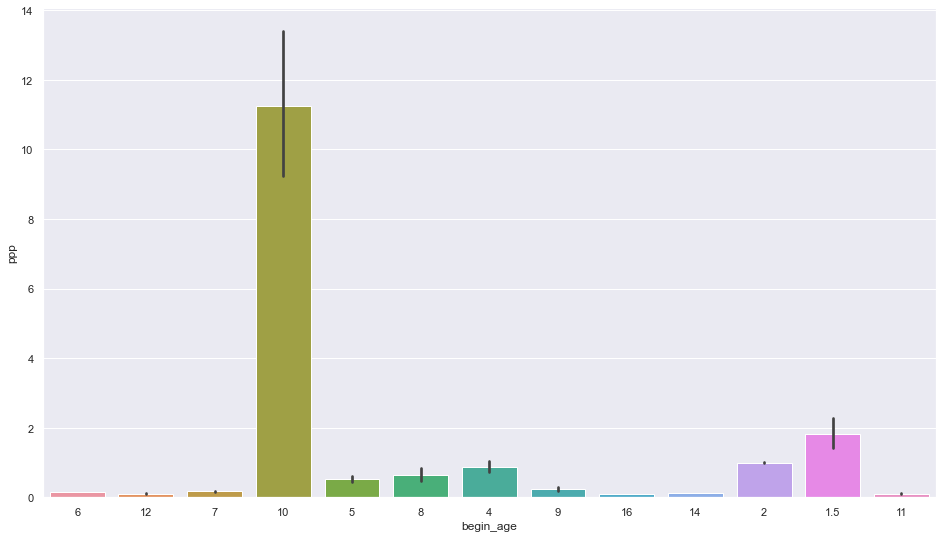

In [524]:
sns.barplot(y='ppp',x='begin_age',data=data)

Observations:



The unit price is the highest when beginning age is 10. It indicates that products with beginning age 10 are the most popular Lego products.


The second highest unit price is when beginning age is 15.



The unit price tends to be higher for younger beginning age since the piece should be bigger in size.



The unit price also tends to be higher for elder beginning age since the product might contain more sophisticated function.

#### A horizontal bar chart between theme_name and ppp.

<AxesSubplot:ylabel='theme_name'>

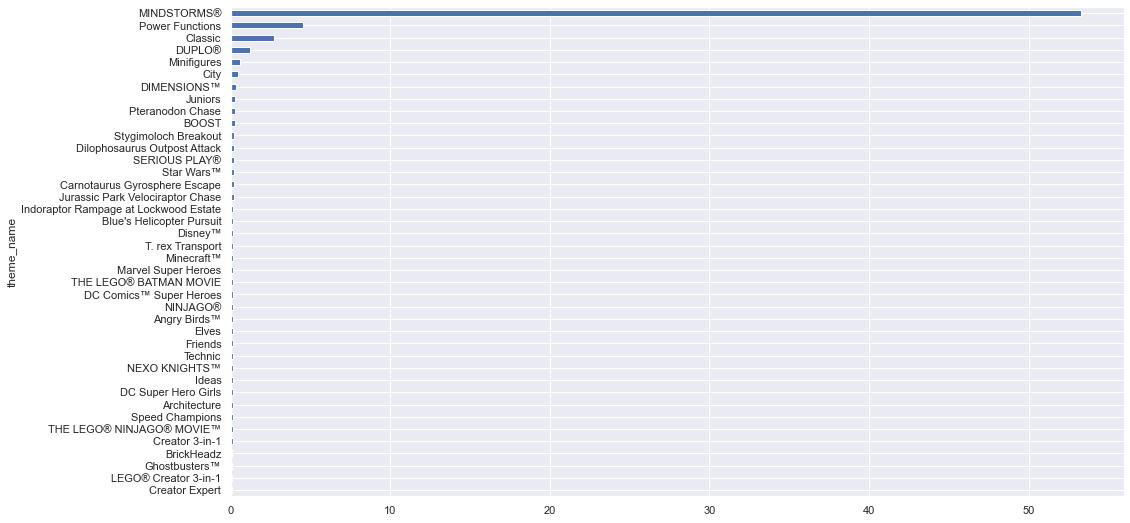

In [516]:
data.groupby('theme_name').mean().sort_values('ppp')['ppp'].plot(kind='barh')

Observation:


Few themes have outstanding ppp values. They are MindStorms, Power Functions, Classic, DUPLO, Minifigures, and City.

#### A horizontal bar chart between theme_name and max ppp.

<AxesSubplot:ylabel='theme_name'>

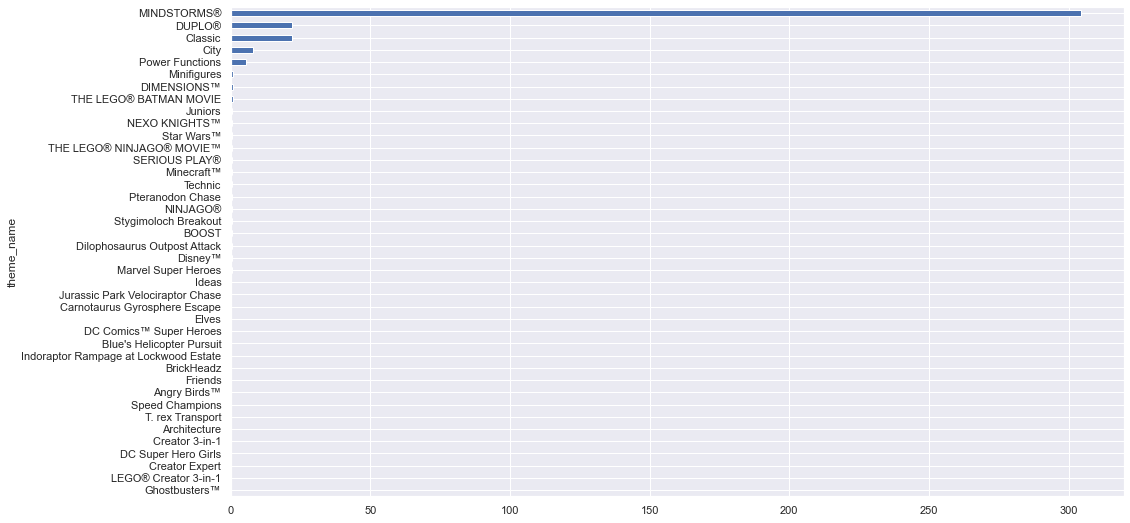

In [517]:
data.groupby('theme_name').max().sort_values('ppp')['ppp'].plot(kind='barh')

#### A horizontal bar chart between review_difficulty and ppp.

<AxesSubplot:ylabel='review_difficulty'>

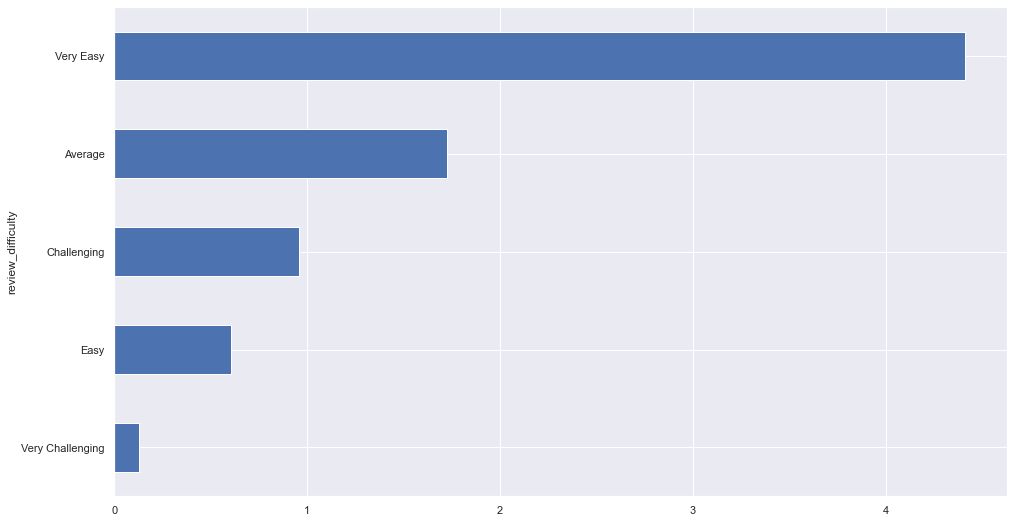

In [518]:
data.groupby('review_difficulty').mean().sort_values('ppp')['ppp'].plot(kind='barh')

Observation:


Products with 'Very Easy' review difficulty have the highest ppp.



Products with 'Very Challenging' review difficulty have the smallest ppp.

#### A horizontal bar chart between star_rating and ppp.

<AxesSubplot:ylabel='star_rating'>

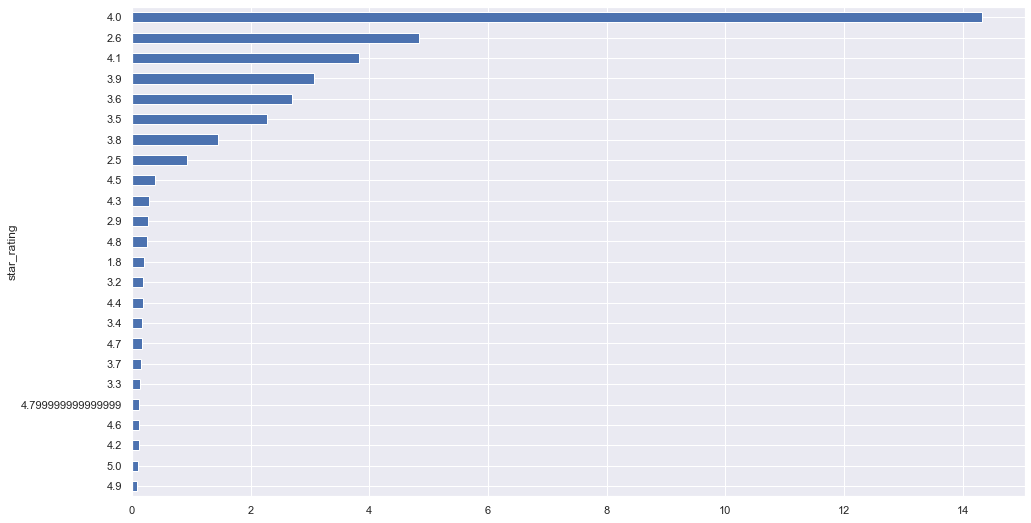

In [519]:
data.dropna()[data.num_reviews >10].groupby('star_rating').mean().sort_values('ppp')['ppp'].plot(kind='barh')

#### A study on set_name and ppp.

In [520]:
df = data.groupby('set_name').mean().sort_values('ppp')['ppp']
df

set_name
Creative Box                                 0.049778
Go Brick Me                                  0.052851
Creative Builder Box                         0.063397
LEGO® Friends Buildable Hedgehog Storage     0.063477
LEGO® Creative Supplement Bright             0.065152
                                              ...    
EV3 Infrared Sensor                         41.924590
EV3 Gyro Sensor                             41.924590
EV3 Color Sensor                            43.093210
EV3 Rechargeable DC Battery                122.484739
EV3 Intelligent Brick                      244.091257
Name: ppp, Length: 741, dtype: float64

In [525]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12261 entries, 0 to 12260
Data columns (total 17 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   ages               12261 non-null  object 
 1   list_price         12261 non-null  float64
 2   num_reviews        10671 non-null  float64
 3   piece_count        12261 non-null  float64
 4   play_star_rating   10665 non-null  float64
 5   prod_desc          12177 non-null  object 
 6   prod_id            12261 non-null  float64
 7   prod_long_desc     12261 non-null  object 
 8   review_difficulty  10665 non-null  object 
 9   set_name           12261 non-null  object 
 10  star_rating        10671 non-null  float64
 11  theme_name         12261 non-null  object 
 12  val_star_rating    10665 non-null  float64
 13  country            12261 non-null  object 
 14  begin_age          12261 non-null  object 
 15  ln_prices          12261 non-null  float64
 16  ppp                122

#### Below is a function to impute missing values using the nearest n neighbors defined by prod_id.

In [563]:
def knn_impute(setname,n):
    ids = data[data.set_name==setname].prod_id.unique()
    for x in ids:
        nrev = []
        rd = []
        sr = []
        vsr = []
        psr = []
        for i in range(1,n+1):
            df = data[data.prod_id==x+i]
            if len(df) > 0:
                nrev.extend(df.num_reviews.values.tolist())
                rd.extend(df.review_difficulty.values.tolist())
                sr.extend(df.star_rating.values.tolist())
                vsr.extend(df.val_star_rating.values.tolist())
                psr.extend(df.play_star_rating.values.tolist())
            df = data[data.prod_id==x-i]
            if len(df) > 0:
                nrev.extend(df.num_reviews.values.tolist())
                rd.extend(df.review_difficulty.values.tolist())
                sr.extend(df.star_rating.values.tolist())
                vsr.extend(df.val_star_rating.values.tolist())
                psr.extend(df.play_star_rating.values.tolist())
        idx = data[data.prod_id==x].index
        data.loc[idx,'num_reviews'] = np.nanmean(nrev)
        data.loc[idx,'play_star_rating'] = np.nanmean(psr)
        data.loc[idx,'star_rating'] = np.nanmean(sr)
        data.loc[idx,'val_star_rating'] = np.nanmean(vsr)
        if len(rd) > 0:
            data.loc[idx,'review_difficulty'] = max(rd,key=rd.count)

Here is a list of set_names that are completely missing on the five items: num_reviews, play_star_rating, review_difficulty, star_rating and val_star_rating.

In [555]:
sn_lists = ['My First Bricks', 'LEGO® DUPLO® Creative Box', 'Bricks on a Roll', 'Darth Maul™', 
            'Zane - Spinjitzu Master', 'Nya - Spinjitzu Master', 'Kai - Spinjitzu Master', 'S.O.G. Headquarters', 
            'LEGO® NEXO KNIGHTS™ Monsters Army-Building Set', 'Battle Suit Macy', 'Battle Suit Lance', 
            'Battle Suit Clay', "Macy's Bot Drop Dragon", "Lance's Hover Jouster", 'Berserker Bomber', 
            "Aaron's X-bow", 'The Nether Fight', 'The Polar Igloo', 'EV3 Cable Pack', 'EV3 Touch Sensor', 
            'EV3 Infrared Sensor', 'EV3 Gyro Sensor', 'Mighty Micros: Scarlet Spider vs. Sandman', 
            'Mighty Micros: Star-Lord vs. Nebula', "Blue's Helicopter Pursuit", 'T. rex Transport', 
            'Police Helicopter Chase', 'Snake Showdown', "Zane's Ninja Boat Pursuit", 'Pteranodon Escape', 
            'Underminer Bank Heist', 'Raptor Rescue Truck', 'T. rex Breakout', "Andrea's Musical Duet", 
            'Puppy Championship', "Stephanie's Soccer Practice", "Mia's Organic Food Market", "Emma's Art Stand", 
            'Heartlake Frozen Yogurt Shop', "Mia's Camper Van", 'My First Plane', 'My First Caterpillar', 
            'My First Truck', 'Doc McStuffins´ Pet Vet Care', 'LEGO® DUPLO® Creative Chest', 
            'Doc McStuffins™ Backyard Clinic', "Cinderella´s Magical Castle", 'My First Race Car', 
            'My First Ladybug', 'My First Bus', 'My First Puzzle Pets', 'Farm Animals', 'My First Celebration', 
            'Birthday Picnic', 'Mickey Racer', 'My First Emotions', "Farmers' Market", 'Airport', 
            'Shooting Gallery', 'Fun Creations', 'Farm Pony Stable', 'My First Animal Brick Box', 
            'Spider-Man & Hulk Adventures', 'Fun Family Fair', 'Minnie Mouse Bow-tique', 'Family House', 
            'Large Playground Brick Box', 'Town Square', 'Farm Adventures', 'T. rex Tower', "Berry's Kitchen", 
            "Petite's Royal Stable", "Elsa's Market Adventure", 'The Powerpuff Girls™ Team Pack', 
            'Teen Titans Go!™ Fun Pack', 'Lena Luthor™ Kryptomite™ Factory', 'Eclipso™ Dark Palace', 
            'Airshow Aces', 'Extreme Engines', 'Sailboat Rescue', 'Road Repair Truck', 'Mountain Police Chase', 
            'Dirt Road Pursuit', 'Mountain River Heist', 'Tactical Batman™ & Superman™', 'Han Solo™']

We do the imputation for each set_name.

In [564]:
for x in sn_lists:
    knn_impute(x,2)

Since there are still few missing observations, we drop them for good.

In [566]:
data.dropna(inplace=True)

In [567]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11572 entries, 0 to 12260
Data columns (total 17 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   ages               11572 non-null  object 
 1   list_price         11572 non-null  float64
 2   num_reviews        11572 non-null  float64
 3   piece_count        11572 non-null  float64
 4   play_star_rating   11572 non-null  float64
 5   prod_desc          11572 non-null  object 
 6   prod_id            11572 non-null  float64
 7   prod_long_desc     11572 non-null  object 
 8   review_difficulty  11572 non-null  object 
 9   set_name           11572 non-null  object 
 10  star_rating        11572 non-null  float64
 11  theme_name         11572 non-null  object 
 12  val_star_rating    11572 non-null  float64
 13  country            11572 non-null  object 
 14  begin_age          11572 non-null  object 
 15  ln_prices          11572 non-null  float64
 16  ppp                115

#### A heatmap to check the correlations between ppp and other numerical variables.

<AxesSubplot:>

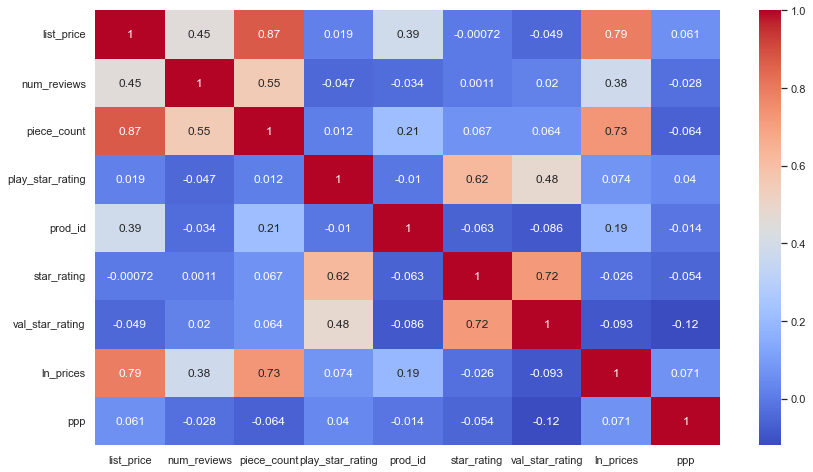

In [568]:
plt.figure(figsize = (14, 8))

sns.heatmap(data.corr(), annot = True, cmap = "coolwarm")

Observation:



ppp is not highly correlated with other numerical variables.

#### Define dummy variables for Categorical variables: 'review_difficulty','set_name','theme_name','country','begin_age'.

In [569]:
df = pd.get_dummies(
        data,
        columns = ['review_difficulty','set_name','theme_name','country','begin_age'],
        drop_first = False,
)

Instead of predicting ppp, we predict ln(ppp).

In [604]:
df['lnppp'] = np.log(df.ppp)

In [605]:
df.columns.tolist()

['ages',
 'list_price',
 'num_reviews',
 'piece_count',
 'play_star_rating',
 'prod_desc',
 'prod_id',
 'prod_long_desc',
 'star_rating',
 'val_star_rating',
 'ln_prices',
 'ppp',
 'review_difficulty_Average',
 'review_difficulty_Challenging',
 'review_difficulty_Easy',
 'review_difficulty_Very Challenging',
 'review_difficulty_Very Easy',
 'set_name_1968 Ford Mustang Fastback',
 'set_name_2016 Ford GT & 1966 Ford GT40',
 'set_name_24 Hours Race Car',
 'set_name_4 x 4 Response Unit',
 'set_name_6x6 All Terrain Tow Truck',
 'set_name_A-Team™ Fun Pack',
 'set_name_A-Wing Starfighter™',
 'set_name_A-Wing™ vs. TIE Silencer™ Microfighters',
 'set_name_ATM Heist Battle',
 'set_name_ATV Arrest',
 'set_name_ATV Race Team',
 "set_name_Aaron's Rock Climber",
 "set_name_Aaron's Stone Destroyer",
 "set_name_Aaron's X-bow",
 'set_name_Adventure Time™',
 'set_name_Adventure Time™ Level Pack',
 'set_name_Adventure Time™ Team Pack',
 'set_name_Ahch-To Island™ Training',
 'set_name_Air Blazer',
 'set_n

#### Spit the data into a training set and a testing set.

In [606]:
ind_vars = df.drop(["ages","list_price", "ln_prices","prod_desc","prod_long_desc","prod_id","ppp","lnppp"], axis = 1)
dep_var = df[["lnppp"]]

In [607]:
x_train, x_test, y_train, y_test = train_test_split(
    ind_vars, dep_var, test_size = 0.3, random_state = 1
)

In [608]:
print("Number of rows in train data =", x_train.shape[0])
print("Number of rows in test data =", x_test.shape[0])

Number of rows in train data = 8100
Number of rows in test data = 3472


#### We build a ridge regression model.

In [609]:
rdg = Ridge()

In [610]:
rdg.fit(x_train, y_train)
model_pref(rdg, x_train, x_test,y_train,y_test)

,Data,RMSE,MAE,MAPE
0,Train,0.085760,0.059601,-359.680840
1,Test,0.094942,0.064156,-23.800443


The model does not seem to be overfitted. 

In [611]:
ridge_regression_perf_test = model_performance_regression(rdg, x_test, y_test)

ridge_regression_perf_test

,RMSE,MAE,R-squared,Adj. R-squared,MAPE
0,0.094942,0.064156,0.992031,0.989660,NaN


$R^{2}$ on the testing data is $99\%$.

#### Compare the predicted ln(ppp) and the actual ln(ppp) on the testing set.

Text(0.5, 1.0, 'Plot of Actual vs. Predicted Responses')

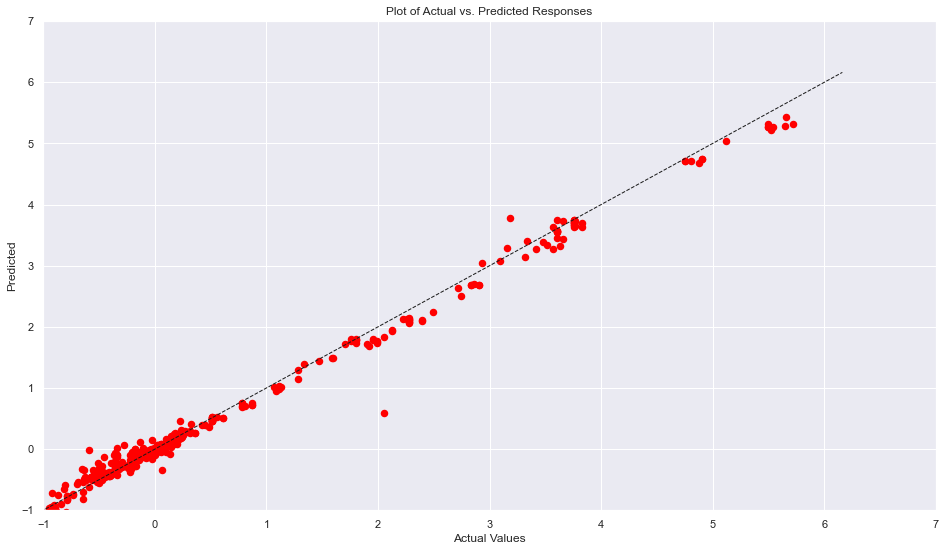

In [613]:
predictions = rdg.predict(x_test)
plt.scatter(y_test.values,predictions.reshape(-1),lw=1.5,color='red')
#plt.plot(prediction_summary['actual'],prediction_summary['obs_ci_lower'],'g--')
#plt.plot(prediction_summary['actual'],prediction_summary['obs_ci_upper'],'g--')
xpoints = ypoints = plt.xlim()
plt.plot(xpoints, ypoints, linestyle='--', color='k', lw=1, scalex=False, scaley=False)
plt.xlim([-1,7])
plt.ylim([-1,7])
plt.xlabel('Actual Values')
plt.ylabel('Predicted')
plt.title('Plot of Actual vs. Predicted Responses')